<h1 style="text-align: center;"><b>Text generation</b></h1>
<h5 style="text-align: center;"><I>Generating poetry from a trained model</I></h5>


#### **1. Executive summary**

This project explores text generation using two different models, LSTM and BERT. My personal poetry collection is used as the input data and the models are trained to generate poetry. The models are evaluated based on the generated text and the training time. The results show that the LSTM model is better at generating an output than the BERT model, primarily because LSTM can string together words and phrases from the input data to create a somewhat coherent output. The LSTM model is also faster to train than the BERT model.

#### **2. Introduction**

Previously I experimented with clustering and topic modeling with my poetry. I used K-means clustering and vectorization initially and found the model to perform poorly, given the limited data and model's lack of complexity to compensate for it. Next I used ELMo word embeddings and tried clustering the themes in the data with both K-means model and the Latent Drichlet Allocation (LDA) model. The LDA model performed much betters, especially when used with an autoencoder to extract features.

The next step in this pipeline is to generate poetry using a text generation model. I will be using a Long Short-Term Memory (LSTM) model to generate poetry. The model will be trained on the poetry corpus and will be able to generate poetry based on the themes in the corpus.

#### **3. Importing packages**

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import random 



#### **4. Preprocessing**

The preprocessing is done using TensorFlow's preprocessing library.

In [4]:
tokenizer = Tokenizer()
data = open('data.txt').read()
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [5]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [6]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [7]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)
label.shape

(3102, 1021)

#### **5. Text generation models**

***Long Short-Term Memory (LSTM) model***

Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) architecture specifically designed to address the vanishing gradient problem in traditional RNNs. This problem arises when training RNNs on long sequences, as gradients either vanish or explode, making it difficult for the network to learn long-range dependencies. LSTMs are capable of learning and retaining information over long sequences, making them suitable for various sequence-to-sequence tasks like language modeling, machine translation, and text generation.

The LSTM architecture introduces memory cells and additional gating mechanisms to control the flow of information within the network. The key components of an LSTM cell are:

- Input gate $(i_t)$
- Forget gate $(f_t)$
- Output gate $(o_t)$
- Cell state $(C_t)$
- Hidden state $(h_t)$


Mathematically, the LSTM cell's operations can be described as follows:

**Input gate $(i_t)$:**
$$i_t = σ(W_i[h_{t-1}, x_t] + b_i)$$
The input gate decides how much of the new input $(x_t)$ and previous hidden state $(h_{t-1})$ should be used to update the cell state. It uses a sigmoid activation function $(σ)$ and learns the weights $(W_i)$ and biases $(b_i)$ during training.

**Forget gate $(f_t)$**:
$$f_t = σ(W_f[h_{t-1}, x_t] + b_f)$$
The forget gate decides how much of the previous cell state $(C_{t-1})$ should be retained or forgotten. It also uses a sigmoid activation function and learns the weights $(W_f)$ and biases $(b_f)$ during training.


**Cell state $(C_t)$:**
$$C_t = f_t * C_{t-1} + i_t * tanh(W_c[h_{t-1}, x_t] + b_c)$$
The cell state is the internal memory of the LSTM cell. It gets updated based on the previous cell state $(C_{t-1})$, input gate $(i_t)$, and a candidate cell state, which is a combination of the previous hidden state $(h_{t-1})$ and current input $(x_t)$ passed through a hyperbolic tangent (tanh) activation function. The weights $(W_c)$ and biases $(b_c)$ are learned during training.


**Output gate $(o_t)$:**
$$o_t = σ(W_o[h_{t-1}, x_t] + b_o)$$
The output gate controls how much of the cell state $(C_t)$ is exposed to the next layer or the next time step. It uses a sigmoid activation function and learns the weights $(W_o)$ and biases $(b_o)$ during training.


**Hidden state $(h_t)$:**
$$h_t = o_t * tanh(C_t)$$
The hidden state is the output of the LSTM cell at each time step. It is a combination of the output gate $(o_t)$ and the cell state $(C_t)$ passed through a hyperbolic tangent $(tanh)$ activation function.

**5.1.1 Training the LSTM model**

In [8]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 139, 100)          102100    
                                                                 
 bidirectional (Bidirectiona  (None, 139, 300)         301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 139, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 510)               51510     
                                                                 
 dense_1 (Dense)             (None, 1021)              521731    
                                                      

In [9]:
#this cell takes some time. Approximately 20minutes
history = model.fit(predictors, label, epochs=500, verbose=1)

Epoch 1/500
97/97 [==============================] - 36s 232ms/step - loss: 7.0075 - accuracy: 0.0513
Epoch 2/500
97/97 [==============================] - 10s 104ms/step - loss: 6.0088 - accuracy: 0.0593
Epoch 3/500
97/97 [==============================] - 6s 59ms/step - loss: 5.7432 - accuracy: 0.0593
Epoch 4/500
97/97 [==============================] - 6s 65ms/step - loss: 5.5742 - accuracy: 0.0632
Epoch 5/500
97/97 [==============================] - 4s 40ms/step - loss: 5.4533 - accuracy: 0.0774
Epoch 6/500
97/97 [==============================] - 3s 28ms/step - loss: 5.3586 - accuracy: 0.0812
Epoch 7/500
97/97 [==============================] - 4s 39ms/step - loss: 5.2606 - accuracy: 0.0874
Epoch 8/500
97/97 [==============================] - 3s 34ms/step - loss: 5.1722 - accuracy: 0.0912
Epoch 9/500
97/97 [==============================] - 2s 25ms/step - loss: 5.0634 - accuracy: 0.0951
Epoch 10/500
97/97 [==============================] - 3s 31ms/step - loss: 4.9614 - accuracy: 0.

**5.1.2 Testing the model**

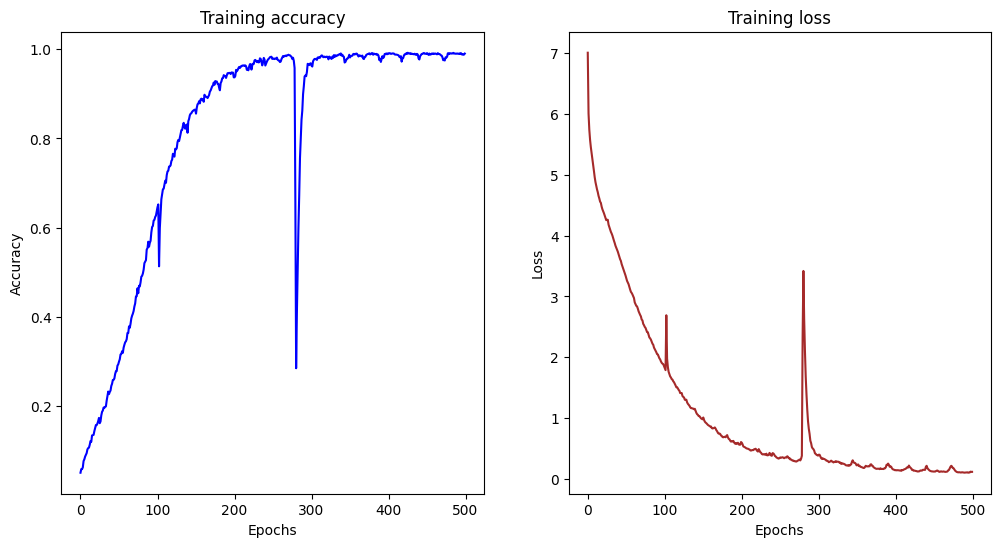

In [12]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 6))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.set_title('Training accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs, loss, color = 'brown', label='Training Loss')
ax2.set_title('Training loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
plt.show()

According to the graphs, the training accuracy consistently increase as the number of epochs increases. It starts to converge to 1 around 300 epochs, right after a sudden drop in the accuracy. However, that could just be a random fluctuation in the accuracy since my previous runs did not show such a dip. 

Accuracy can be a misleading metric at times though, so I also looked at the loss function. The loss function is a measure of how well the model is performing. The lower the loss, the better the model is performing. The loss function is calculated as the difference between the predicted value and the actual value. The loss function is calculated for each epoch and the average loss is plotted in the graph. A similar trend is observed in the loss of the model as well. The loss starts to converge to 0 around 300 epochs, right after a sudden spike in the loss.


In [13]:
seed_text = "You are standing on a cliff and you hear the sound of the ocean and the wind"
next_words = 100

In [18]:
def generate_text(seed_text, next_words): 
  for _ in range(next_words):
      token_list = tokenizer.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
      predictions = model.predict(token_list, verbose=0)
      predicted_index = np.argmax(predictions[0])
      output_word = ""
      for word, index in tokenizer.word_index.items():
          if index == predicted_index:
              output_word = word
              break
      seed_text += " " + output_word
  return seed_text

print(generate_text(seed_text, next_words))

You are standing on a cliff and you hear the sound of the ocean and the wind way my eyes burn like dragon fire under the sun or the way my jaw works every time i try hiding my smiles from you would the absence of our exploding selves ever fill in the way our eyes meet in a crowd of cluttering birds readying for flight tell me if our souls had not found each other in the way the sun finds the sky would we have wandered right off the edge of the world never knowing that the earth was round to the boy with smiles like the dying they you want to say things when


The first test showed a somewhat coherent output. Complete sentences are not present and there is no punctuation, which makes it harder to read the results. I wanted to try a few more examples, with varying length to see how the model is generating text. 

In [19]:
#testing the model on a few other seed texts of varrying length

seeds = ['Once upon a time...', 
         'And the skies split open to the sound of your battle cry', 
         'Blue',
         'In an alternative universe, we live in blushing expanse of the skies. We live from airport to airport and sit in hidden corners with our heads against each others',
         '']

for seed in seeds:
  print(generate_text(seed, next_words))
  print('------------------------------')

Once upon a time... i feel everything i am a survivor coming home to a broken world my lungs become an abyss with an end attached to the back of my hand i try touching my finger with my finger and weep when it breaks my body is a map of a planet without a sun no matter how hard i search for the x i always feel it everywhere 90 beyond repair so i just stay here contraption of wielding light when your hands scribble poetry in expansive attempts to capture my beauty and the way my hands fit in yours without ever
------------------------------
And the skies split open to the sound of your battle cry body all that calcium and phosphate and collegian all wasted on walking on eggshells and persian rugs why is the rhythm of your feet so reticent why are you not walking on war drums and frozen lakes to you clench your heart you suck in a breath before the glinting sword comes down at you and your hands shake when you hold the little girl crying for her mother you are not used to something so fr

After inspecting the output, it is very clear that the model is merely stringing together words and phrases from the input data. However, the combination of words is interesting. There seems to be thematic clustering to some extent, though it doesn't relate much to the seed text. The first output for example, primarily has phrases related to body parts, while the second output carries a similar tone of anger and grief in most of its phrases. This might be because these features have been identified by the model and hence the output is based on these features.

-------------------------------

***BERT***

BERT is a pre-trained language model developed by Google. It is a bidirectional transformer-based model that uses a self-attention mechanism to learn contextual representations of words. The model is trained on a large corpus of text and can be fine-tuned on a variety of downstream tasks. 

BERT is built upon the Transformer architecture, which was introduced by Vaswani et al. in their paper "Attention is All You Need." The key components of the BERT model are:

1. Multi-Head Self-Attention Mechanism
2. Position-wise Feed-Forward Networks
3. Layer Normalization
4. Positional Encoding

BERT is a very advanced and complicated model but a high level pseudoalgorithm of the model is as follows:

1. **Load pre-trained BERT model and tokenizer**.

2. **Tokenize input text**:
<br>
    a. Add special tokens [CLS] at the beginning and [SEP] at the end of the text.
    <br>
    b. Apply WordPiece tokenization to the input text.
    <br> c. Convert tokens into token IDs using the tokenizer's vocabulary.

3. **Create input features**:<br>
    a. Token IDs: The sequence of token IDs obtained from step 2.c.<br>
    b. Segment IDs: A binary mask to differentiate between different sentences (0 for the first sentence and 1 for the   second sentence, if applicable).<br>
    c. Position IDs: A sequence of integers representing the position of each token in the input.<br>
    d. Attention Mask: A binary mask indicating the positions of non-padding tokens.<br>

4. **Forward pass through the BERT model**:<br>
    a. Embed token IDs, segment IDs, and position IDs.<br>
    b. Pass the embeddings through a stack of Transformer encoder layers.<br>
    c. For each layer:<br>
    * i. Apply multi-head self-attention mechanism.<br>
    * ii. Add the attention output to the input and apply layer normalization.<br>
    * iii. Pass the result through a position-wise feed-forward network.<br>
    * iv. Add the feed-forward output to the input and apply layer normalization.<br>
    
    d. Obtain the final output representations for each token.<br>

5. **Fine-tune BERT for a specific task (if necessary):**<br>
    a. Add a task-specific output layer on top of the BERT model.<br>
    b. Train the model using labeled data for the target task, updating the weights with backpropagation.<br>

6. **Perform inference for the target task:**<br>
    a. For classification tasks, use the representation of the [CLS] token and pass it through the task-specific output layer.<br>
    b. For token-level tasks, use the representations of the individual tokens and pass them through the task-specific output layer.<br>
    c. Apply the appropriate activation function and compute the final predictions.<br>

**5.2.1 Training the BERT model**

In [21]:
#pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.1 MB/s eta 0:00:00


In [22]:
# Import necessary libraries
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForMaskedLM

In [23]:
# Load pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
# Prepare data
data = open('data.txt').read()
train_data = data[:int(len(data)*0.8)]
val_data = data[int(len(data)*0.8):]

# Tokenize data
train_tokens = tokenizer.encode(train_data, add_special_tokens=True, max_length = 512, truncation = True)
val_tokens = tokenizer.encode(val_data, add_special_tokens=True, max_length = 512, truncation = True)

In [26]:
# Fine-tune the BERT model on the poetry corpus
optimizer = torch.optim.Adam(model_bert.parameters(), lr=5e-5)
model_bert.train()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [27]:
for epoch in range(500):
    for i in range(0, len(train_tokens), 512):
        input_ids = torch.tensor(train_tokens[i:i+512]).unsqueeze(0)
        labels = input_ids.clone()
        labels[labels == tokenizer.pad_token_id] = -100
        optimizer.zero_grad()
        outputs = model_bert(input_ids, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

**5.2.2 Testing the model**

In [33]:
# Generate new poetry
model_bert.eval()
input_text = 'And the skies split open to the sound of your battle cry'
input_ids = tokenizer.encode(input_text, add_special_tokens=True, return_tensors='pt')
with torch.no_grad():
    outputs = model_bert.generate(input_ids, max_length=100, do_sample=True, temperature=0.85)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

and the skies split open to the sound of your battle cry............. * * * * * * * * * * * * * * * * * * * * * * *.... * * * * * * * * * * * * * * * * * * * * * * * * * *... * * * * sky overhead split * * sound split split split split split * *


The output is barely coherent, very few words outside of the seed text are present. The model seems to be repeating the same thing over and over again. This might be because BERT is a more complex model and requires a lot more training data to perform well. The model was trained on a small dataset, which might not be enough for the model to learn the nuances of the language. 

#### **6. Discussion**

On first glance, the LSTM model seems to be performing better than BERT, however, it would be unfair to compare the two models since they are very different in nature. BERT is a pre-trained model that can be fine-tuned on a variety of downstream tasks. It is a very complex model that requires a lot of training data to perform well. On the other hand, the LSTM model is a custom model that was trained on a small dataset. The LSTM model is a simpler model that is easier to train and understand.

BERT might perform a lot better with more data and more training time. Instead of just repeating words from the input data like LSTM, BERT might be able to generate something more original. 

#### **7. References**

https://towardsdatascience.com/nlp-text-generation-through-bidirectional-lstm-model-9af29da4e520

#### **8. AI tools**

ChatGPT was used in the project to understand the algorithm behind BERT. BERT is a complicated model and the research papers introducing it are very long and difficult to understand. ChatGPT simplified the concept enough for me have a higher level understanding of the model.